In [263]:
import time
import re
import scipy.io
import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

def get_data_from_matlab(matlab_file_path):

    matlab_data = scipy.io.loadmat(matlab_file_path)

    ts = matlab_data['time1'].flatten()
    ys = matlab_data['dataEng1']
    ys = jnp.array(ys[:, 2:])

    return ts, ys

def extract_velocity(filename):
    match = re.search(r'DAQ1_(\d+(?:p\d+)?)', filename)
    if match:
        return float(match.group(1).replace('p', '.'))
    else:
        raise ValueError(f"Could not extract velocity from {filename}")

In [267]:
class ODELSTMCell(eqx.Module):
    weight_C: eqx.nn.Linear
    weight_x: eqx.nn.Linear
    odefunc: eqx.nn.MLP

    hidden_size: int = eqx.field(static=True)
    input_size: int = eqx.field(static=True)

    def __init__(self, input_size: int, hidden_size: int, key: jax.Array):
        self.hidden_size = hidden_size
        self.input_size = input_size

        key_C, key_x, key_ode = jax.random.split(key, 3)

        self.weight_C = eqx.nn.Linear(hidden_size, hidden_size, key=key_C)
        self.weight_x = eqx.nn.Linear(input_size, hidden_size, key=key_x)

        self.odefunc = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size,
            width_size=hidden_size,
            depth=2,
            key=key_ode
        )

    def ode_rhs(self, t: float, C: jax.Array, x: jax.Array) -> jax.Array:
        """ODE dynamics: dC/dt = g(C, x)"""
        ode_input = self.weight_C(C) + self.weight_x(x)
        return self.odefunc(ode_input)

    @jax.named_scope("ODELSTMCell")
    def __call__(self, x: jax.Array, C: jax.Array, *, key=None) -> jax.Array:
        """Performs one ODE-LSTM step, evolving C forward in time."""
        solver = diffrax.Euler()
        term = diffrax.ODETerm(self.ode_rhs)
        save_state = diffrax.SaveAt(ts=[1.0])

        sol = diffrax.diffeqsolve(
            term,
            solver,
            t0=0.0,
            t1=1.0,
            dt0=0.1,
            y0=C,
            args=x,
            saveat=save_state
        )

        return sol.ys[0]


In [268]:
class ODELSTM(eqx.Module):
    lstm: ODELSTMCell
    linear: eqx.nn.Linear

    def __init__(self, input_size, hidden_size, output_size, key):
        lstm_key, linear_key = jr.split(key, 2)
        self.lstm = ODELSTMCell(input_size=input_size, hidden_size=hidden_size, key=lstm_key)
        self.linear = eqx.nn.Linear(in_features=hidden_size, out_features=output_size, key=linear_key)

    def __call__(self, x: jnp.ndarray, velocity: float):
        c = jnp.full(self.lstm.hidden_size, velocity * 0.1)
        c = self.lstm(x, c)
        output = self.linear(c)
        return output

def train_odelstm(datasets, input_size, hidden_size, output_size, num_epochs, batch_size, learning_rate, key):
    model_key, key = jr.split(key)
    model = ODELSTM(input_size, hidden_size, output_size, key=model_key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

    all_data = []
    for dataset in datasets:
        for i in range(len(dataset) - 1):
            all_data.append((dataset[i], dataset[i + 1, :2]))

    perm_key, key = jr.split(key)
    perm = jr.permutation(perm_key, len(all_data))
    all_data = [all_data[i] for i in perm]


    batch_inputs = jnp.stack([item[0] for item in all_data])
    batch_targets = jnp.stack([item[1] for item in all_data])

    @eqx.filter_value_and_grad
    def compute_loss(model, batch_inputs, batch_targets):
        velocities = batch_inputs[:, -1]
        predictions = jax.vmap(model)(batch_inputs, velocities)
        loss = jnp.mean((predictions - batch_targets) ** 2)
        return loss

    @eqx.filter_jit
    def make_step(model, opt_state, batch_inputs, batch_targets):
        loss, grads = compute_loss(model, batch_inputs, batch_targets)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    num_batches = len(batch_inputs) // batch_size
    for epoch in range(num_epochs):
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(batch_inputs))
            loss, model, opt_state = make_step(model, opt_state, batch_inputs[start_idx:end_idx], batch_targets[start_idx:end_idx])
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

    return model

dataset_paths =  [
    "GPPHMAY2014/Regular Waves/V7p3knots/DAQ1_7p3_FP_RW_May14_Run48.mat",
    "GPPHMAY2014/Regular Waves/V25p0knots/DAQ1_25_BP_RW_May14_Run19.mat",
    "GPPHMAY2014/Regular Waves/V25p0knots/DAQ1_25_FP_RW_May14_Run56.mat",
    "GPPHMAY2014/Regular Waves/V25p0knots/DAQ1_25_FP_RW_May14_Run57.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_BP_RW_May14_Run20.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_BP_RW_May14_Run21.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_BP_RW_May14_Run22.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_FP_RW_May14_Run38.mat",
    "GPPHMAY2014/Regular Waves/V25p0knots/DAQ1_25_FP_RW_May14_Run58.mat",
    "GPPHMAY2014/Regular Waves/V25p0knots/DAQ1_25_FP_RW_May14_Run59.mat",
    "GPPHMAY2014/Regular Waves/V7p3knots/DAQ1_7p3_FP_RW_May14_Run49.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_FP_RW_May14_Run39.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_FP_RW_May14_Run40.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_MP_RW_May14_Run28.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_MP_RW_May14_Run29.mat",
    "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_MP_RW_May14_Run30.mat"
]

datasets = []

for path in dataset_paths:
    data = get_data_from_matlab(path)[1]
    velocity = extract_velocity(path)
    velocity_column = jnp.full((data.shape[0], 1), velocity)
    data_with_velocity = jnp.hstack((data, velocity_column))
    datasets.append(data_with_velocity)

input_size = datasets[0].shape[1]
hidden_size = 32
output_size = 2
num_epochs = 3
batch_size = 32
learning_rate = 1e-5
key = jr.PRNGKey(0)

ode_model = train_odelstm(datasets, input_size, hidden_size, output_size, num_epochs, batch_size, learning_rate, key)

Epoch 1/3, Loss: 0.0031
Epoch 2/3, Loss: 0.0000
Epoch 3/3, Loss: 0.0000


In [269]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

def evaluate_model(model, filename):
    ts, ys = get_data_from_matlab(filename)
    velocity = extract_velocity(filename)
    ys_jax = jnp.array(ys)
    
    velocity_column = jnp.full((ts.shape[0], 1), velocity)
    velocities_jax = jnp.array(velocity_column)

    ys_jax_with_velocities = jnp.array(jnp.concatenate([ys_jax, velocities_jax, velocities_jax], axis=1))

    predictions = jax.vmap(lambda x: model(x[:-1], x[-1]))(ys_jax_with_velocities)

    true_initial_value = ys_jax[0, :2]
    predicted_initial_value = predictions[0, :]
    offset = true_initial_value - predicted_initial_value
    predictions += offset
    
    dimension_names = ["Heave", "Pitch"]
    fig, axes = plt.subplots(len(dimension_names), 1, figsize=(10, 20))

    for i, name in enumerate(dimension_names):
        ax = axes[i]
        ax.plot(ts, ys[:, i], label=f"Real ({name})", linestyle='dashed', c="blue")
        ax.plot(ts, predictions[:, i], label=f"Model ({name})", c="crimson")
        ax.set_title(name)
        ax.legend()

    plt.tight_layout()
    plt.show()

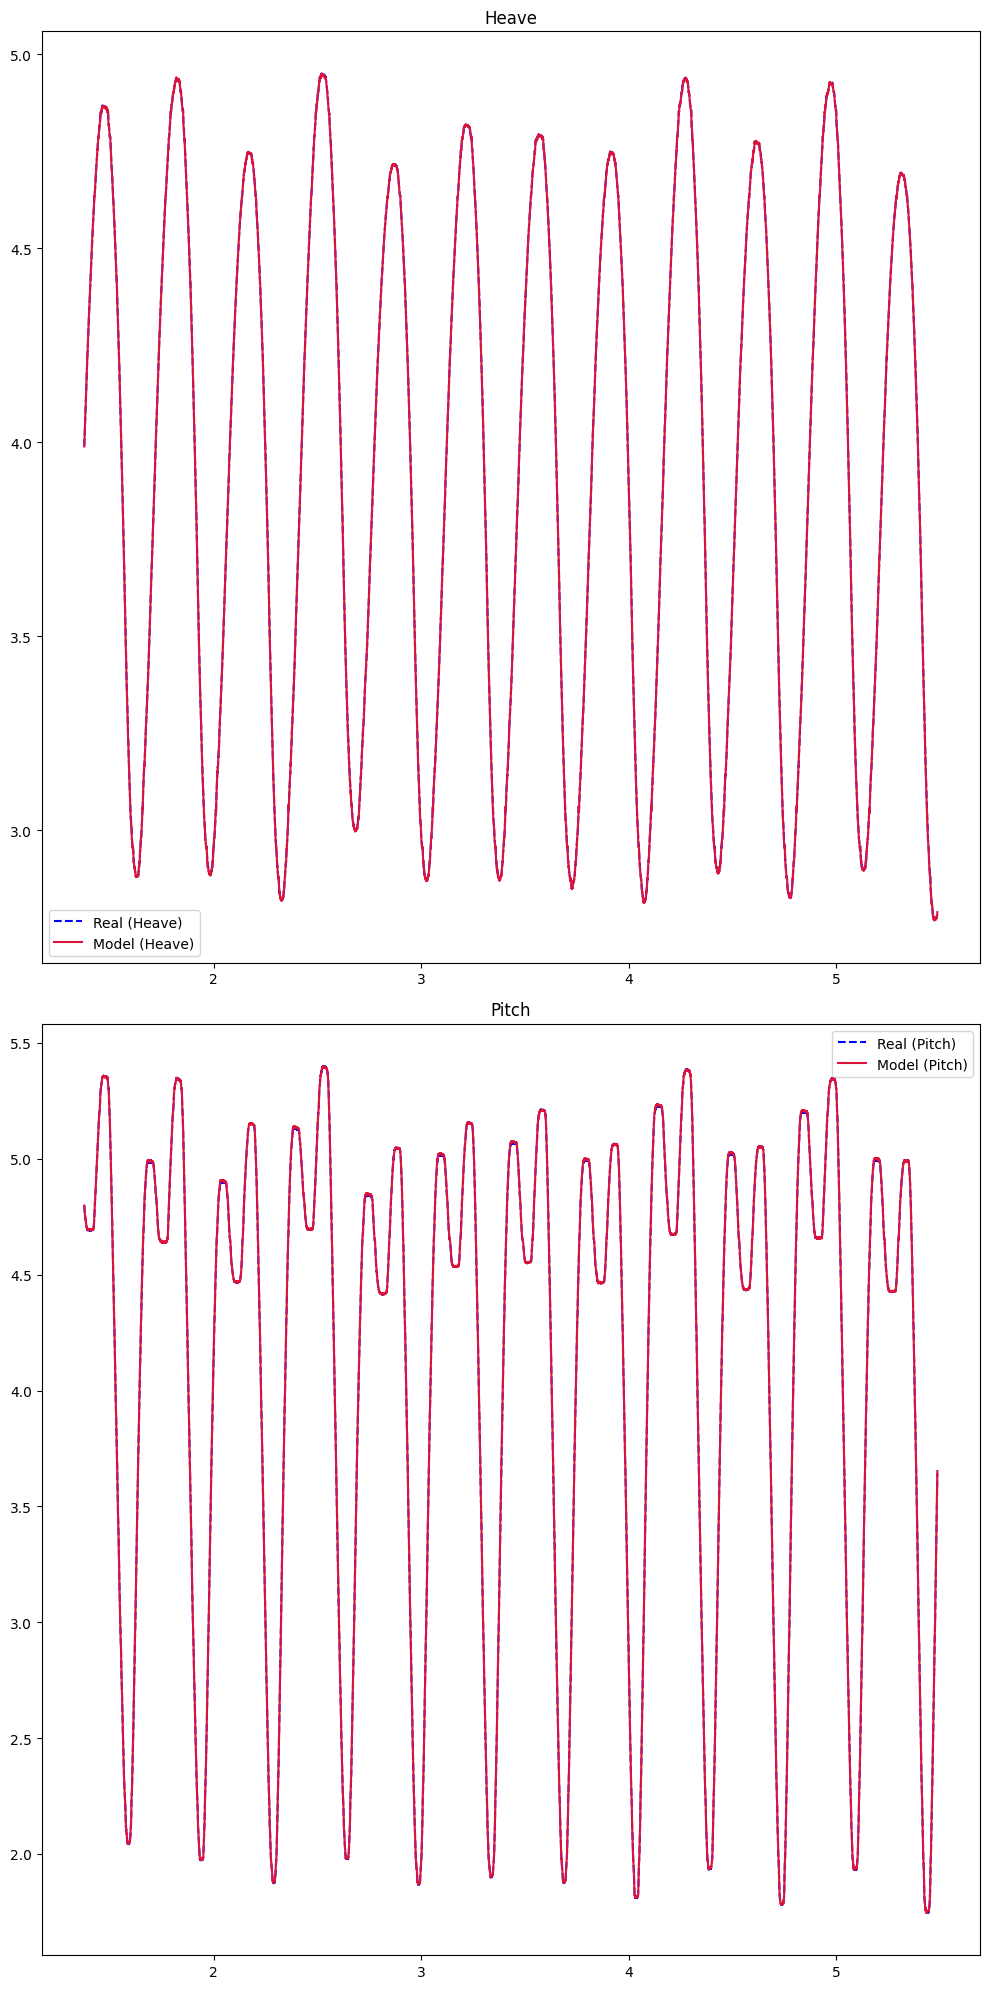

In [270]:
evaluate_model(ode_model, "GPPHMAY2014/Regular Waves/V29p5knots/DAQ1_29p5_MP_RW_May14_Run76.mat")

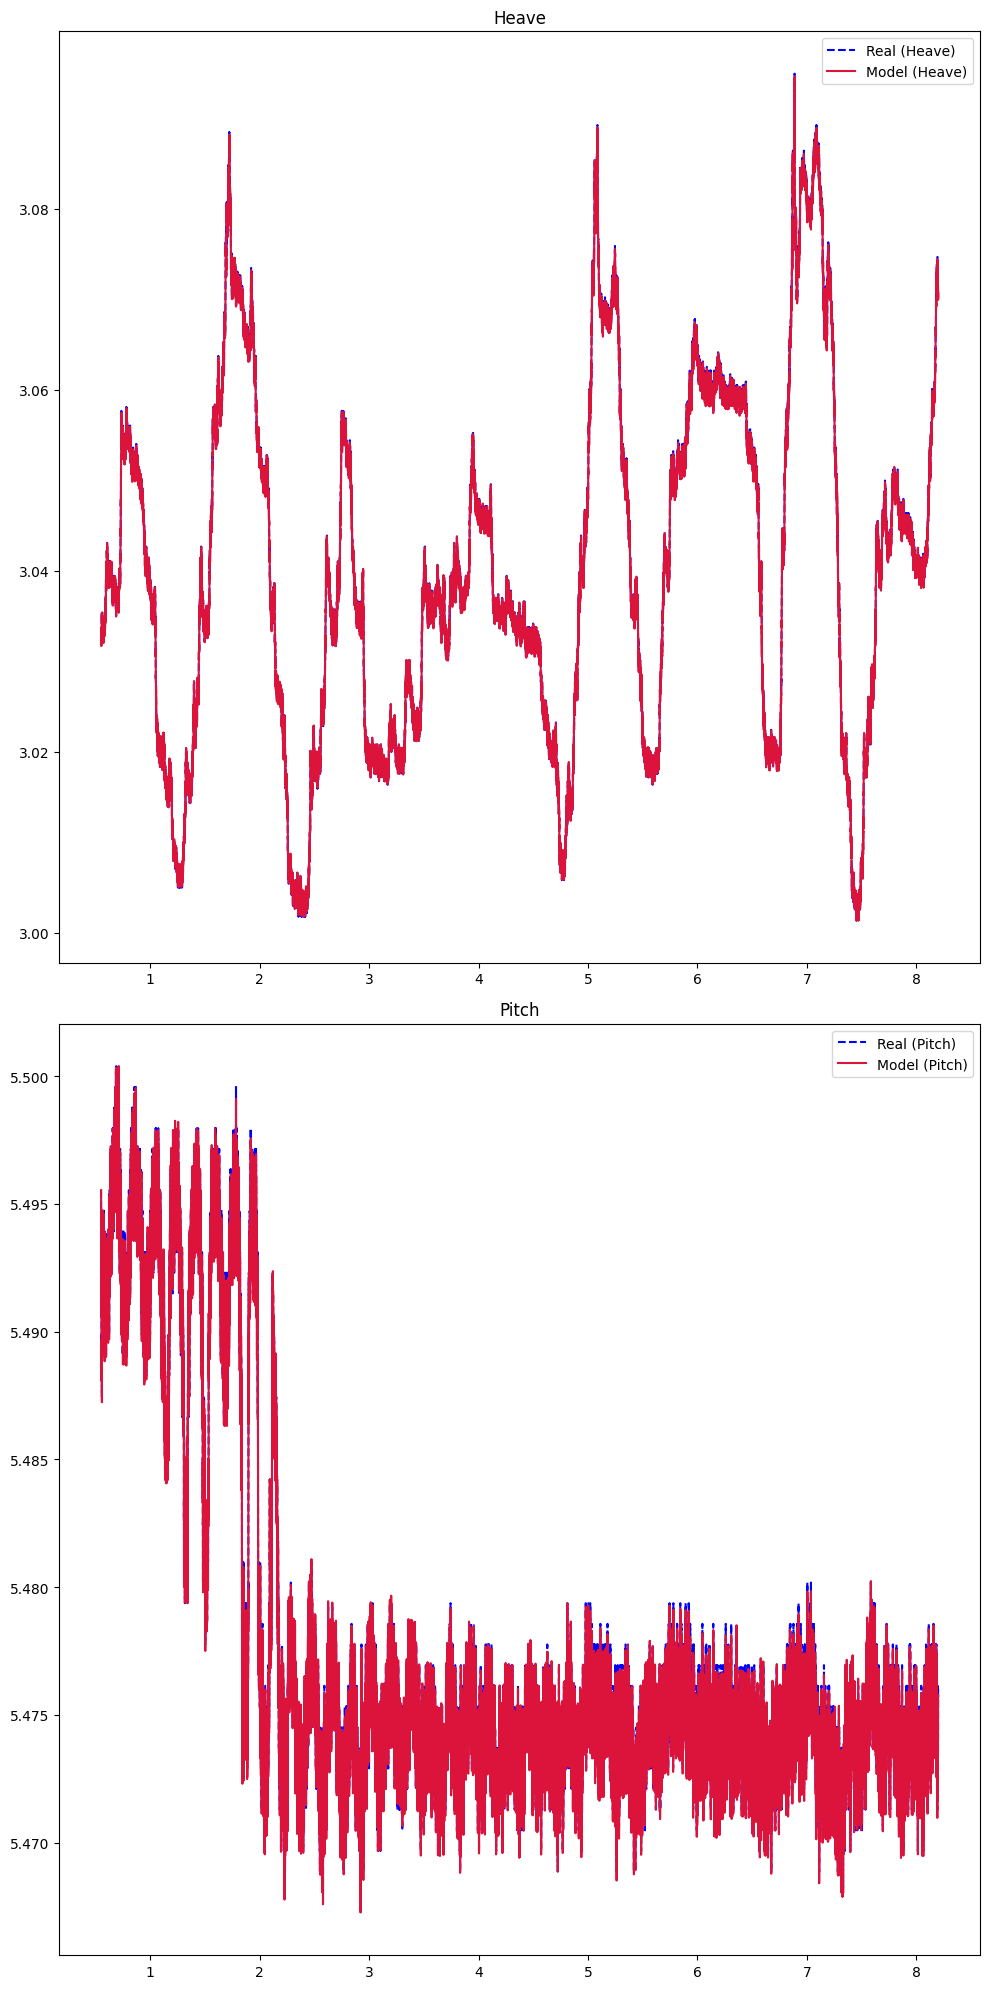

In [271]:
evaluate_model(ode_model, "GPPHMAY2014/Calm Water/V22p0knots/DAQ1_22_BPCW_CW_May14_Run4.mat")

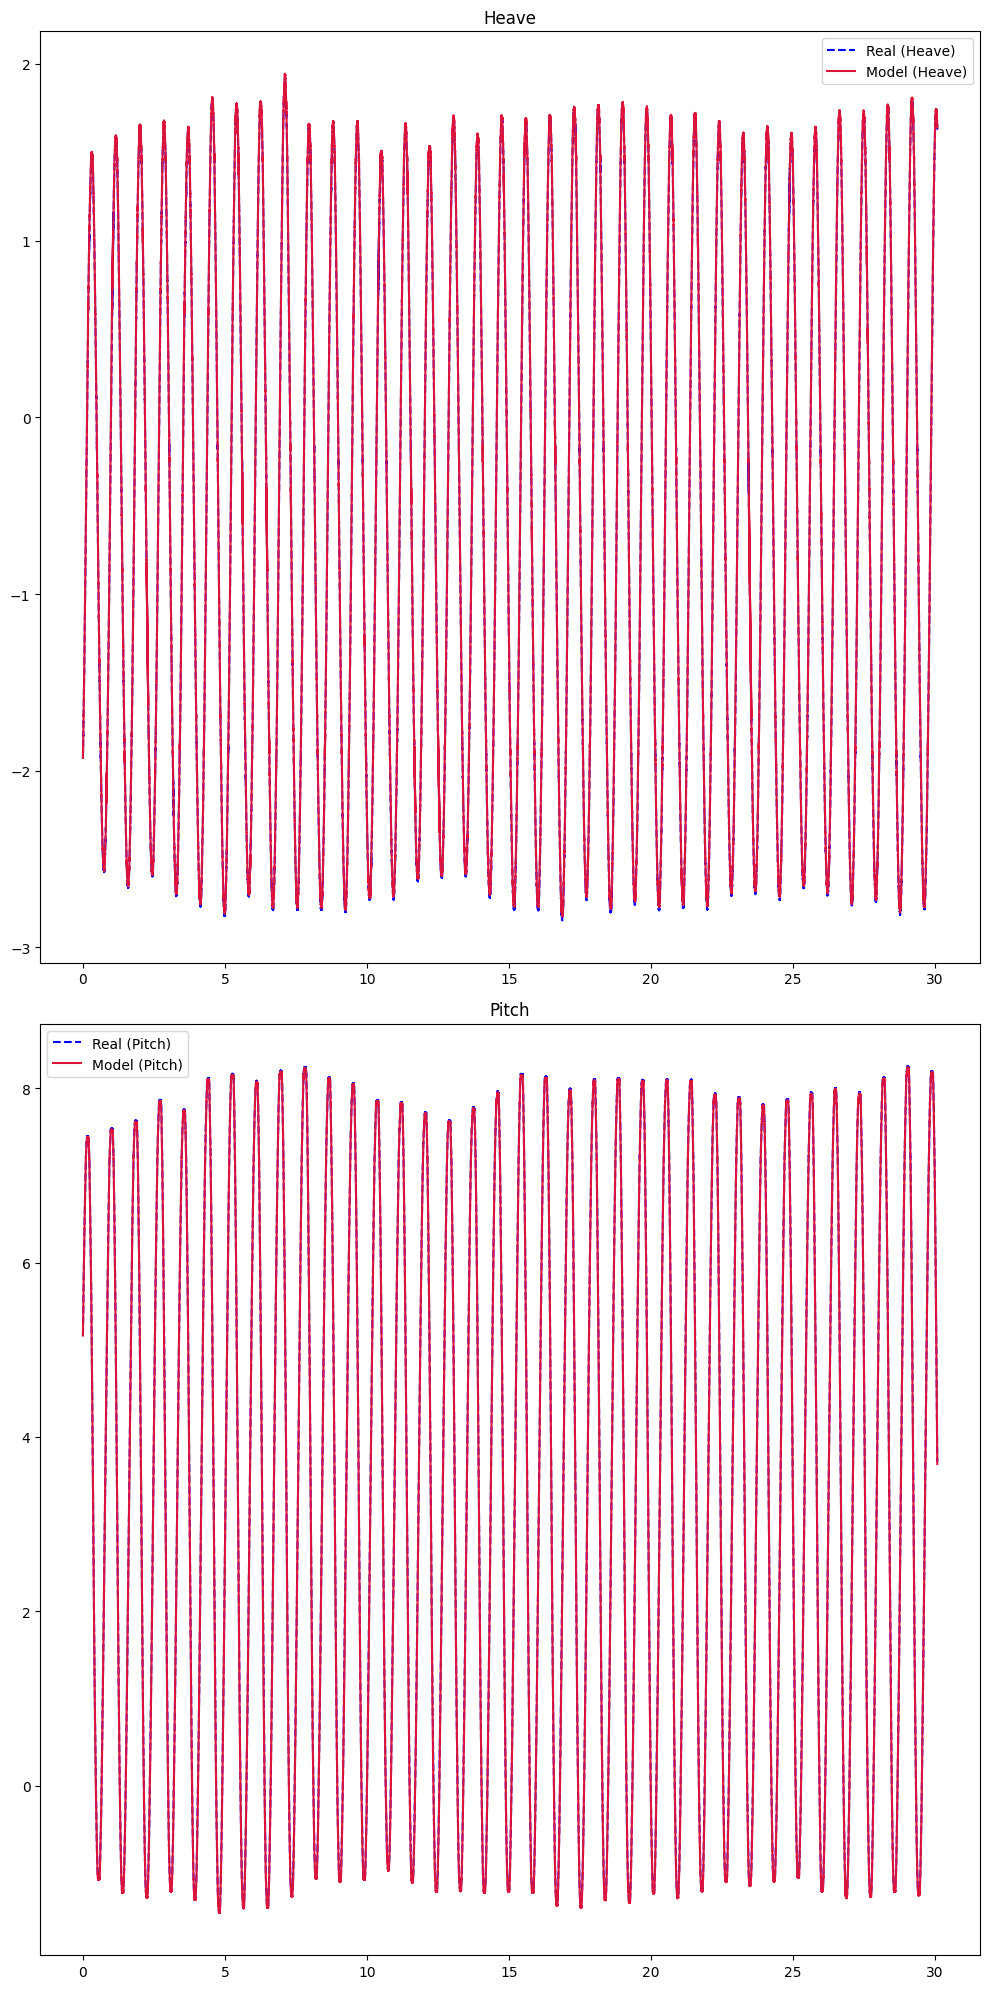

In [257]:
evaluate_model(ode_model, "GPPHMAY2014/Regular Waves/V7p3knots/DAQ1_7p3_FP_RW_May14_Run50.mat")
